# LSTM Time Series Forecasting: COVID-19 Daily New Cases in Egypt
We are interested in predicting the next **daily new cases** using the last 5 enteries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

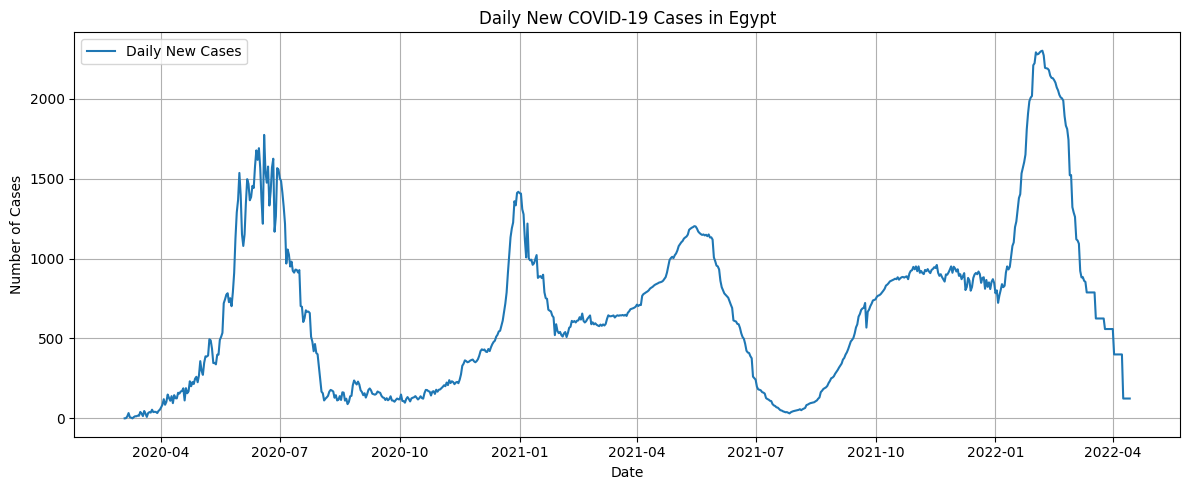

In [ ]:
# Load Egypt daily COVID-19 data
df = pd.read_csv('egypt_daily_covid.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)

# Visualize daily new cases
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['daily_new_cases'].ffill().fillna(0), label='Daily New Cases')
plt.title('Daily New COVID-19 Cases in Egypt')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
df.head()

,date,country,daily_new_cases
0,2020-03-04,Egypt,0
1,2020-03-05,Egypt,1
2,2020-03-06,Egypt,12
3,2020-03-07,Egypt,33
4,2020-03-08,Egypt,7


In [108]:
# Prepare the time series
series = df['daily_new_cases'].ffill().fillna(0).values


In [109]:
# split train and test sets
train_size = int(len(series) * 0.8)

train_set = series[:train_size]
test_set = series[train_size:]

In [110]:
# Data scaling
scaler = MinMaxScaler()

train_set = scaler.fit_transform(train_set.reshape(-1,1))
test_set = scaler.transform(test_set.reshape(-1,1))


In [121]:
# check shapes and scaling
print(train_set.shape)
print(train_set.max())

print(test_set.shape)
print(test_set.max())


(617, 1)
1.0
(155, 1)
1.2970687711386697


In [112]:
# Sequence creation
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):   #We subtract window_size to avoid out of bound indexing error
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X).squeeze(-1), np.array(y).squeeze(-1)

window_size = 5
X_train, y_train = create_sequences(train_set, window_size)
X_test, y_test = create_sequences(test_set, window_size)




In [113]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Reshaping for input layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Input_dim = X_train[0].shape
print(Input_dim)


(612, 5)
(612,)
(150, 5)
(150,)
(5, 1)


In [114]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=Input_dim))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

#Early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [115]:
# train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=20,
                    validation_split=0.2, callbacks=[es])



Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1560 - mae: 0.3126 - mse: 0.1560 - val_loss: 0.0655 - val_mae: 0.1973 - val_mse: 0.0655
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0917 - mae: 0.2290 - mse: 0.0917 - val_loss: 0.0159 - val_mae: 0.1176 - val_mse: 0.0159
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0230 - mae: 0.1263 - mse: 0.0230 - val_loss: 0.0242 - val_mae: 0.1405 - val_mse: 0.0242
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0177 - mae: 0.1156 - mse: 0.0177 - val_loss: 0.0082 - val_mae: 0.0832 - val_mse: 0.0082
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0133 - mae: 0.0895 - mse: 0.0133 - val_loss: 0.0043 - val_mae: 0.0590 - val_mse: 0.0043
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0067 - mae: 0.0639 - mse: 0.0067 - val_loss: 0.0017 - val_mae: 0.0327 - val_mse: 0.0017
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0045 - mae: 0.0473 - mse: 0.0045 - val_loss: 0.0020 - val_m

In [117]:
# Evaluate on test set
loss, MAE, MSE   = model.evaluate(X_test, y_test)
print("Test Dataset loss: ", loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0441 - mse: 0.0040        
Test Dataset loss:  0.005982300266623497


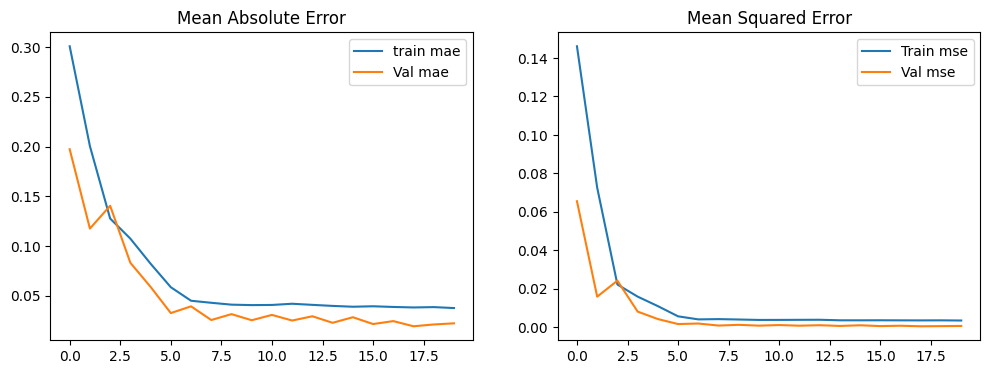

In [124]:
# visualize mae and mse
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='Val mae')
plt.title('Mean Absolute Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train mse')
plt.plot(history.history['val_mse'], label='Val mse')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

In [118]:
# Prediction and rescaling to actual values
pred = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(pred.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


<Figure size 1200x500 with 0 Axes>

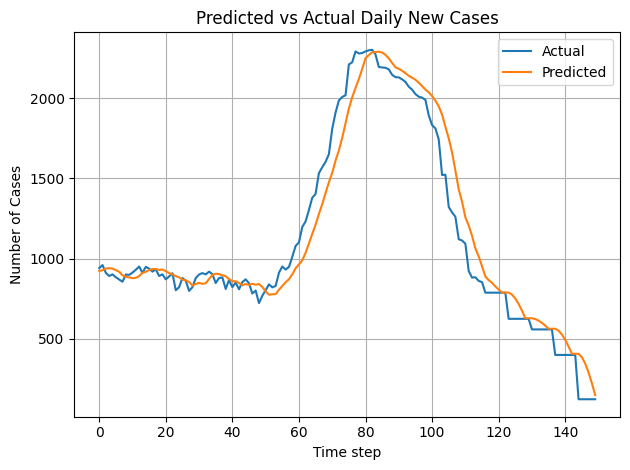

In [119]:
# Visualize Prediced vs Actual daily new cases on test set

plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual')
plt.plot(range(len(y_test_rescaled)), pred_rescaled, label='Predicted')

plt.title('Predicted vs Actual Daily New Cases')
plt.xlabel('Time step')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

